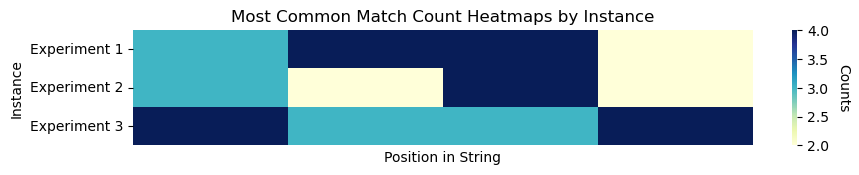

In [33]:
import os
import pandas as pd


# The following is used to generate, for each experiment, a comparison of solutions obtained from P number of runs.
# We pass a list of strings
# Note that the alphabet, for this case, is hard-coded for ATGC.


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import Counter

def plot_string_heatmap_with_legend(strings):
    # Determine the length of the strings (assuming all strings are of equal length)
    string_length = len(strings[0])
    
    # Create a mapping for characters to numeric values for color encoding
    # This is to generate a heatmap, but the colors only signify the character identity; we'll represent this in the legend
    unique_chars = sorted(set("".join(strings)))  # Get unique characters in sorted order
    char_to_num = {char: i for i, char in enumerate(unique_chars)}
    num_to_char = {i: char for char, i in char_to_num.items()}  # Reverse mapping for legend

    # Initialize a matrix to store the numeric values for each string's characters
    color_matrix = np.zeros((len(strings), string_length))
    
    # Fill the matrix with numeric values based on character encoding
    # Each position in a string, therefore, will get a color based on character, for easy visualization.
    for i, string in enumerate(strings):
        color_matrix[i] = [char_to_num[char] for char in string]
    
    # Plot the heatmap
    plt.figure(figsize=(10, len(strings) * 0.3 + 2))
    sns.heatmap(color_matrix, annot=False, cmap="viridis", cbar=False, xticklabels=False, yticklabels=range(1, len(strings) + 1))
    plt.xlabel("Position in String")
    plt.ylabel("Solution String")
    plt.title("Solution Population Heatmap")
    
    # Create a custom legend, where we use the actual alphabet letters instead of numbers
    legend_elements = [Patch(facecolor=sns.color_palette("viridis", len(unique_chars))[i], 
                             label=num_to_char[i]) for i in range(len(unique_chars))]
    
    plt.legend(handles=legend_elements, title="Characters", bbox_to_anchor=(1.05, 1), loc='upper left')
    


def plot_match_count_heatmap(strings, experiment_name):
    # Determine the length of the strings (assuming all strings are of equal length)
    string_length = len(strings[0])
    
    # Initialize a list to store match counts for each position
    match_counts = []

    # Calculate the match count for each position
    for pos in range(string_length):
        # Collect all characters at this position across strings
        chars_at_pos = [string[pos] for string in strings]
        # Find the most common character count
        most_common_count = Counter(chars_at_pos).most_common(1)[0][1]
        match_counts.append(most_common_count)
    
    # Convert match counts to a 2D array with one row for heatmap compatibility
    match_counts_array = np.array([match_counts])

    # Plot the 1D heatmap
    plt.figure(figsize=(10, 5))
    # I disable x-ticks, as in the previous function, because we have TOO many positions in our strings. It's cluttered.
    sns.heatmap(match_counts_array, annot=True, cmap="YlGnBu", cbar=True, xticklabels=False, yticklabels=False)
    plt.xlabel("Position in String")
    plt.ylabel(experiment_name)
    plt.title("Match Count Heatmap by Position")







# The main.py script for Project 6 will have produced a .csv file that summarizes the results of all runs.
# This summarized result simply is a csv file that has a run's best solution's fitness data appended to it.
# Thus, we can get a population of P solutions from P total runs.
# This code block will simply summarize the results of ALL experiments (like a summary of summaries).
# Each experiment will also have all P solutions added to a strings list.
# This will be used to construct a heatmap that visualizes the most common matches between the solution strings.
# This may be a helpful prerequisite for thinking about combining solutions.
# But it may also be a way to visualize the extend to which different GA runs converge in solutions.
# That is, will multiple runs have many common matches at each kth position?


# Initialize a list to collect results as dictionaries
# We can later convert this list of dictionary to a DataFrame
results_list = []

# To be passed as an argument to our heatmap function for all instances
all_strings = []
all_experiments = []


# Get all the experiment directories in the results directory
# Generally, each experiment will be named after the .csp file instance
for experiment_dir in os.listdir('results/'):
    experiment_path = os.path.join('results', experiment_dir)
    
    if os.path.isdir(experiment_path):
        # Look in the experiment directory....

        print(f"Processing data from {experiment_dir}...")
        
        # Initialize lists to store data for averaging
        min_hamming_distances = []
        max_hamming_distances = []
        lambdas = []
        runtimes = []

        # For experiment-specific heatmap
        strings = []
        
        # Grab the names of all files and directories in the experiment directory.
        # Of course, the only .csv that I've coded to be saved here is the run_solutions_fitness_data.csv
        for run_solution in os.listdir(experiment_path):
            print(f"Considering {run_solution}...")
            run_solution_path = os.path.join(experiment_path, run_solution)

            # The only .csv file here should be the run_solutions_fitness_data
            if run_solution.endswith('.csv'):

                # Read the CV and assign to df
                df = pd.read_csv(run_solution_path)


                # Break the df apart into lists, each containing a column's data
                # Extend DataFrame column to lists.
                # Simple way is to convert df columns to list using .tolist()
                # Then extend to our empty list.
                min_hamming_distances.extend(df['min_hamming_distance'].tolist())
                max_hamming_distances.extend(df['max_hamming_distance'].tolist())
                lambdas.extend(df['lambda(average)'].tolist())
                runtimes.extend(df['runtime'].tolist())
                strings.extend(df['solution_string'].tolist())

                # For creating a matchcount heatmap for ALL instances
                all_strings.append(strings)
                
                plot_string_heatmap_with_legend(strings)
                plt.savefig(experiment_path + '/solution_strings_heatmap.png')
                plt.close()


                plot_match_count_heatmap(strings, experiment_dir)
                plt.savefig(experiment_path + '/solution_strings_matchcount.png')
                plt.close()
                
                # Calculate statistics for 'best' result
                # First, we find index of whichever row has the smallest average value
                best_index = lambdas.index(min(lambdas))

                # Use the index of the minimum average ('best') to get the other data values, which will have same index
                best_min_hamming_distance = min_hamming_distances[best_index]
                best_max_hamming_distance = max_hamming_distances[best_index]
                best_lambda = lambdas[best_index]
                best_runtime = runtimes[best_index] # THIS IS A SPECIFIC RUNTIME FOR THE RUN THAT GENERATED THE BEST
                
                # Calculate statistics for 'avg' result
                # These are straight forward.
                avg_min_hamming_distance = sum(min_hamming_distances) / len(min_hamming_distances)
                avg_max_hamming_distance = sum(max_hamming_distances) / len(max_hamming_distances)
                avg_lambda = sum(lambdas) / len(lambdas)
                avg_runtime = sum(runtimes) / len(runtimes) # THIS IS AN AVERAGE RUNTIME FROM ALL RUNS


                # The reason for the following two is this:
                # For each instance, I want the best solution's fitness data (best -> based on min average(lambda))
                # Also, for each instance, I want the average solution fitness of the runs.
                # This is a common table to see in primary literature

                
                # Add 'best' result to the results list
                # note that the runtime here is specific
                results_list.append({
                    'instance': experiment_dir,
                    'result_summary': 'best',
                    'min_hamming_distance': best_min_hamming_distance,
                    'max_hamming_distance': best_max_hamming_distance,
                    'lambda(average)': best_lambda,
                    'runtime': best_runtime
                })
                
                # Add 'avg' result to the results list
                results_list.append({
                    'instance': experiment_dir,
                    'result_summary': 'avg',
                    'min_hamming_distance': avg_min_hamming_distance,
                    'max_hamming_distance': avg_max_hamming_distance,
                    'lambda(average)': avg_lambda,
                    'runtime': avg_runtime
                })

# Convert the list of dictionaries to a DataFrame, nice and easy.
results_df = pd.DataFrame(results_list)

# Print to double-check
print(results_df)

# save the DataFrame to a CSV file. I can easily use this to add to a report.
results_df.to_csv('results_summary.csv', index=False)


Processing data from RandomACGT_20_3000_GC72...
Considering solution_strings_matchcount_raster.png...
Considering run_0...
Considering solution_strings_matchcount.png...
Considering solution_strings_heatmap.png...
Considering run_solutions_fitness_data.csv...
Considering run_1...
Processing data from RandomACGT_20_2000_GC72...
Considering solution_strings_matchcount_raster.png...
Considering run_0...
Considering solution_strings_matchcount.png...
Considering solution_strings_heatmap.png...
Considering run_solutions_fitness_data.csv...
Considering run_1...
Processing data from RandomACGT_10_2000_GC72...
Considering solution_strings_matchcount_raster.png...
Considering run_0...
Considering solution_strings_matchcount.png...
Considering solution_strings_heatmap.png...
Considering run_solutions_fitness_data.csv...
Considering run_1...
Processing data from RandomACGT_20_5000_GC72...
Considering solution_strings_matchcount_raster.png...
Considering run_0...
Considering solution_strings_match